In [1]:
import cv2
import numpy as np
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
# Read the files in the Data Folder
files = os.listdir("Data/")
print(files)

# Generate the labels for each video class
labels = [i for i in range(len(files))]
print(labels)

['Bend', 'Jack', 'Jump', 'Pjump', 'Run', 'Side', 'Skip', 'Walk', 'Wave1', 'Wave2']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [3]:
# This function computes the optical flow for all the consequitive frames of the video
def optical_flow(cap):
    Flow = []
    ret, old_frame = cap.read()
    while True:
        ret, new_frame = cap.read()
        if ret:
            prvs = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
            new = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
            flow = cv2.calcOpticalFlowFarneback(prvs, new, None,0.5, 3, 15, 3, 5, 1.2, 0)
            Flow.append(flow)
            old_frame = new_frame
        else:
            break
    return np.array(Flow)

In [4]:
def optical_flow_amp(Flow):
    AMP = []
    for flow in Flow:
        u = flow[...,0] 
        v = flow[...,1]

        amp = np.sqrt(u**2 + v**2) 
        AMP.append(amp)
    return np.array(AMP)

In [5]:
def amp_threshold(AMP):
    alpha = 0.15
    threshold = alpha * np.max(AMP)
    for i in range(len(AMP)):

        AMP[i][AMP[i]<threshold] = 0
        AMP[i][AMP[i]>=threshold] = 1
    return AMP

In [6]:
def MHI(cap):
    
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    Flow = optical_flow(cap)
    Flow_AMP = optical_flow_amp(Flow)
    AMP_Threshold = amp_threshold(Flow_AMP)
    
    
    MHI_old = np.zeros((frameHight,frameWidth))
    MHI_new = np.zeros((frameHight,frameWidth))
    
    tau = frameCount - 1
    for i in range(tau):
        if i == 0:
            MHI_old[AMP_Threshold[i] == 1] = tau
        else:
            MHI_new[AMP_Threshold[i] == 1] = tau
            MHI_new[AMP_Threshold[i] == 0] = np.maximum(MHI_old[AMP_Threshold[i] == 0]-1,0)

            MHI_old = MHI_new
            
    return MHI_new

In [7]:
Data_path = "Data/"
video_path = Data_path + files[1]

Bend_videos = os.listdir(video_path)
print(Bend_videos[0])
Example_video = video_path+ "/" + Bend_videos[0]

clip1 = VideoFileClip(Example_video)
cap = cv2.VideoCapture(Example_video)

daria_jack.avi


In [8]:
clip1.ipython_display(width = 250)

 99%|████████████████████████████████████████████████████████████████████████████████ | 89/90 [00:00<00:00, 310.39it/s]


(144, 180)
<class 'numpy.ndarray'>


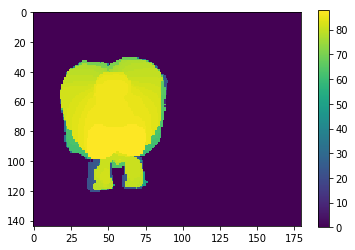

In [9]:
MHI_image = MHI(cap)
print(MHI_image.shape)
print(type(MHI_image))
fig = plt.figure()
plt.imshow(MHI_image)
plt.colorbar()
plt.show()
fig.savefig("Figures/MHI.jpg")

In [72]:
label_list = []
label_number = 0

for file in files:
    label_number+=1
    class_path = Data_path + file
    videos_list = os.listdir(class_path)
    
    for video_name in videos_list:
        label_list.append(label_number)
label_list = np.array(label_list)
print(label_list.shape)

(93,)


In [73]:
MHI_list = []

for file in files:
    label_number+=1
    class_path = Data_path + file
    
    videos_list = os.listdir(class_path)
    
    for video_name in videos_list:
        
        video_path = class_path + "/" + video_name
        
        cap = cv2.VideoCapture(video_path)
        MHI_image = MHI(cap)
        
        MHI_list.append(MHI_image)

MHI_data = np.array(MHI_list)

In [74]:
print(MHI_data.shape)

(93, 144, 180)


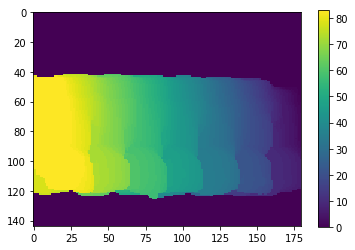

In [75]:
plt.figure()
plt.imshow(MHI_data[65])
plt.colorbar()
plt.show()

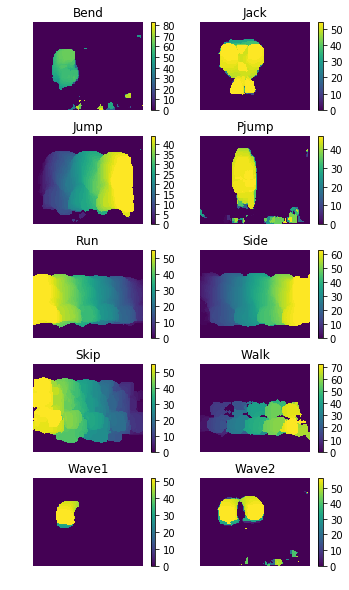

In [76]:
fig, axs = plt.subplots(5, 2, figsize = (6,10))
fig.subplots_adjust (hspace = 0.3, wspace = 0)
axs = axs.ravel()


for i in range(10):
    index = 10*i
    label_index = label_list[index]
    axs[i].axis('off')
    im = axs[i].imshow(MHI_data[index])
    fig.colorbar(im,ax = axs[i])
    axs[i].set_title(files[label_index-1])
fig.savefig('Figures/all_MHI.jpg', bbox_inches = 'tight')

In [77]:
# Normalization Function
def Normalize(X):
    
    for i in range(len(X)):

        mean = np.mean(X[i])
        std = np.sqrt(np.var(X[i]))

        X[i] = (X[i]-mean)/std
    
    return X

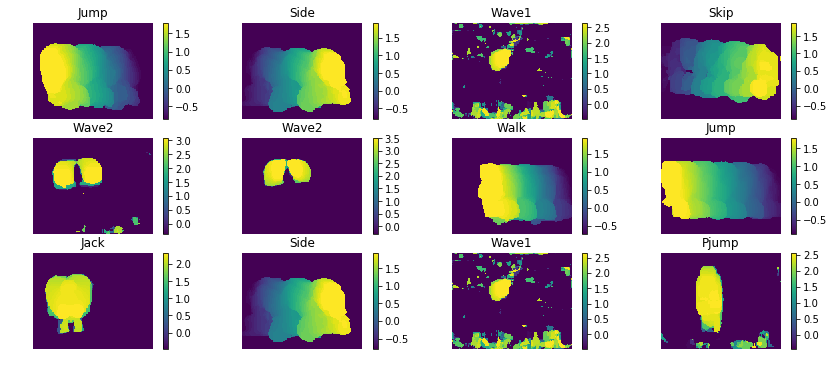

In [78]:
X_normalized = Normalize(MHI_data)
fig, axs = plt.subplots(3, 4, figsize = (15,6))
fig.subplots_adjust (hspace = 0.2, wspace = 0.001)
axs = axs.ravel()

for i in range(12):
    index = random.randint(0, len(MHI_data)-1)
    label_index = label_list[index]
    axs[i].axis('off')
    im = axs[i].imshow(X_normalized[index])
    fig.colorbar(im,ax = axs[i])
    axs[i].set_title(files[label_index-1])



In [79]:
aug_data = np.flip(X_normalized, axis= 2)

#X_normalized = np.concatenate((X_normalized, aug_data), axis =0)
#label_list = np.concatenate((label_list,label_list))

In [80]:
X_normalized = np.expand_dims(X_normalized, axis = 3)
print(X_normalized.shape)
print(label_list.shape)

(93, 144, 180, 1)
(93,)


In [81]:
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, Flatten, MaxPooling2D, Activation, Dropout

In [82]:
model = Sequential()

model.add(Convolution2D(6, 5, 5, input_shape = (144, 180, 1)))
model.add(Activation("relu"))

model.add(MaxPooling2D((2,2), strides= (2,2), border_mode= 'valid'))

model.add(Convolution2D(16,5,5))
model.add(Activation('relu'))

model.add(MaxPooling2D((2,2), strides= (2,2), border_mode= 'valid'))

model.add(Flatten())

model.add(Dense(120))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(84))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

In [83]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(label_list)

In [84]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, nb_epoch =300, validation_split = 0, shuffle = True)

Epoch 1/300
93/93 [==============================] - ETA: 2s - loss: 2.3413 - acc: 0.218 - ETA: 0s - loss: 2.9158 - acc: 0.187 - 2s - loss: 3.2311 - acc: 0.1505     
Epoch 2/300
93/93 [==============================] - ETA: 0s - loss: 2.9071 - acc: 0.250 - ETA: 0s - loss: 2.6792 - acc: 0.171 - 1s - loss: 2.6655 - acc: 0.1505     
Epoch 3/300
93/93 [==============================] - ETA: 0s - loss: 2.2005 - acc: 0.218 - ETA: 0s - loss: 2.2897 - acc: 0.156 - 1s - loss: 2.2860 - acc: 0.1720     
Epoch 4/300
93/93 [==============================] - ETA: 0s - loss: 2.1969 - acc: 0.250 - ETA: 0s - loss: 2.1096 - acc: 0.296 - 1s - loss: 2.1712 - acc: 0.2473     
Epoch 5/300
93/93 [==============================] - ETA: 0s - loss: 2.1054 - acc: 0.312 - ETA: 0s - loss: 2.1902 - acc: 0.187 - 1s - loss: 2.1669 - acc: 0.1613     
Epoch 6/300
93/93 [==============================] - ETA: 0s - loss: 2.0169 - acc: 0.218 - ETA: 0s - loss: 2.0464 - acc: 0.218 - 1s - loss: 2.0626 - acc: 0.2258     
Epoc

93/93 [==============================] - ETA: 1s - loss: 0.1506 - acc: 1.000 - ETA: 0s - loss: 0.3651 - acc: 0.906 - 1s - loss: 0.3527 - acc: 0.9032     
Epoch 51/300
93/93 [==============================] - ETA: 0s - loss: 0.2697 - acc: 0.875 - ETA: 0s - loss: 0.2282 - acc: 0.921 - 1s - loss: 0.2185 - acc: 0.9247     
Epoch 52/300
93/93 [==============================] - ETA: 0s - loss: 0.5258 - acc: 0.812 - ETA: 0s - loss: 0.6063 - acc: 0.781 - 1s - loss: 0.5488 - acc: 0.8065     
Epoch 53/300
93/93 [==============================] - ETA: 1s - loss: 0.3040 - acc: 0.906 - ETA: 0s - loss: 0.4025 - acc: 0.859 - 1s - loss: 0.4354 - acc: 0.8280     
Epoch 54/300
93/93 [==============================] - ETA: 1s - loss: 0.3851 - acc: 0.906 - ETA: 0s - loss: 0.2787 - acc: 0.906 - 1s - loss: 0.2718 - acc: 0.9247     
Epoch 55/300
93/93 [==============================] - ETA: 0s - loss: 0.3319 - acc: 0.875 - ETA: 0s - loss: 0.3463 - acc: 0.875 - 1s - loss: 0.3941 - acc: 0.8495     
Epoch 56/30

93/93 [==============================] - ETA: 0s - loss: 0.1560 - acc: 0.937 - ETA: 0s - loss: 0.1704 - acc: 0.953 - 1s - loss: 0.1884 - acc: 0.9462     
Epoch 100/300
93/93 [==============================] - ETA: 0s - loss: 0.3501 - acc: 0.843 - ETA: 0s - loss: 0.2562 - acc: 0.890 - 1s - loss: 0.2793 - acc: 0.8710     
Epoch 101/300
93/93 [==============================] - ETA: 0s - loss: 0.1144 - acc: 0.937 - ETA: 0s - loss: 0.1270 - acc: 0.937 - 1s - loss: 0.1014 - acc: 0.9570     
Epoch 102/300
93/93 [==============================] - ETA: 0s - loss: 0.2598 - acc: 0.875 - ETA: 0s - loss: 0.1908 - acc: 0.906 - 1s - loss: 0.1835 - acc: 0.9032     
Epoch 103/300
93/93 [==============================] - ETA: 1s - loss: 0.4532 - acc: 0.812 - ETA: 0s - loss: 0.3166 - acc: 0.859 - 1s - loss: 0.2274 - acc: 0.9032     
Epoch 104/300
93/93 [==============================] - ETA: 0s - loss: 0.2001 - acc: 0.937 - ETA: 0s - loss: 0.2076 - acc: 0.937 - 1s - loss: 0.1744 - acc: 0.9355     
Epoch 

93/93 [==============================] - ETA: 0s - loss: 0.1536 - acc: 0.937 - ETA: 0s - loss: 0.0978 - acc: 0.968 - 1s - loss: 0.1001 - acc: 0.9570     
Epoch 148/300
93/93 [==============================] - ETA: 0s - loss: 0.1402 - acc: 0.968 - ETA: 0s - loss: 0.1711 - acc: 0.921 - 1s - loss: 0.2332 - acc: 0.9247     
Epoch 149/300
93/93 [==============================] - ETA: 1s - loss: 0.0216 - acc: 1.000 - ETA: 0s - loss: 0.1141 - acc: 0.953 - 1s - loss: 0.0894 - acc: 0.9677     
Epoch 150/300
93/93 [==============================] - ETA: 1s - loss: 0.1907 - acc: 0.906 - ETA: 0s - loss: 0.1236 - acc: 0.953 - 1s - loss: 0.0883 - acc: 0.9677     
Epoch 151/300
93/93 [==============================] - ETA: 1s - loss: 0.3852 - acc: 0.843 - ETA: 0s - loss: 0.2624 - acc: 0.890 - 1s - loss: 0.1959 - acc: 0.9247     
Epoch 152/300
93/93 [==============================] - ETA: 0s - loss: 0.2515 - acc: 0.906 - ETA: 0s - loss: 0.2599 - acc: 0.906 - 1s - loss: 0.1831 - acc: 0.9355     
Epoch 

93/93 [==============================] - ETA: 0s - loss: 0.0728 - acc: 0.968 - ETA: 0s - loss: 0.0568 - acc: 0.984 - 1s - loss: 0.0502 - acc: 0.9892     
Epoch 196/300
93/93 [==============================] - ETA: 0s - loss: 0.0522 - acc: 1.000 - ETA: 0s - loss: 0.1073 - acc: 0.953 - 1s - loss: 0.0898 - acc: 0.9677     
Epoch 197/300
93/93 [==============================] - ETA: 0s - loss: 0.1144 - acc: 0.937 - ETA: 0s - loss: 0.1073 - acc: 0.953 - 1s - loss: 0.1433 - acc: 0.9462     
Epoch 198/300
93/93 [==============================] - ETA: 0s - loss: 0.2084 - acc: 0.937 - ETA: 0s - loss: 0.2652 - acc: 0.921 - 1s - loss: 0.1921 - acc: 0.9462     
Epoch 199/300
93/93 [==============================] - ETA: 0s - loss: 0.0617 - acc: 0.968 - ETA: 0s - loss: 0.1805 - acc: 0.937 - 1s - loss: 0.2293 - acc: 0.9140     
Epoch 200/300
93/93 [==============================] - ETA: 0s - loss: 0.0832 - acc: 0.968 - ETA: 0s - loss: 0.1082 - acc: 0.953 - 1s - loss: 0.1176 - acc: 0.9462     
Epoch 

93/93 [==============================] - ETA: 0s - loss: 0.1255 - acc: 0.968 - ETA: 0s - loss: 0.0894 - acc: 0.968 - 1s - loss: 0.1173 - acc: 0.9677     
Epoch 244/300
93/93 [==============================] - ETA: 0s - loss: 0.0988 - acc: 0.937 - ETA: 0s - loss: 0.0999 - acc: 0.937 - 1s - loss: 0.1260 - acc: 0.9355     
Epoch 245/300
93/93 [==============================] - ETA: 0s - loss: 0.1197 - acc: 0.937 - ETA: 0s - loss: 0.0978 - acc: 0.937 - 1s - loss: 0.1185 - acc: 0.9355     
Epoch 246/300
93/93 [==============================] - ETA: 0s - loss: 0.0161 - acc: 1.000 - ETA: 0s - loss: 0.1027 - acc: 0.953 - 1s - loss: 0.1351 - acc: 0.9462     
Epoch 247/300
93/93 [==============================] - ETA: 0s - loss: 0.0781 - acc: 0.968 - ETA: 0s - loss: 0.0465 - acc: 0.984 - 1s - loss: 0.0691 - acc: 0.9677     
Epoch 248/300
93/93 [==============================] - ETA: 0s - loss: 0.0086 - acc: 1.000 - ETA: 0s - loss: 0.0910 - acc: 0.968 - 1s - loss: 0.1089 - acc: 0.9462     
Epoch 

93/93 [==============================] - ETA: 1s - loss: 0.1073 - acc: 0.937 - ETA: 0s - loss: 0.0711 - acc: 0.968 - 1s - loss: 0.0928 - acc: 0.9570     
Epoch 292/300
93/93 [==============================] - ETA: 0s - loss: 0.0338 - acc: 1.000 - ETA: 0s - loss: 0.0585 - acc: 0.984 - 1s - loss: 0.0447 - acc: 0.9892     
Epoch 293/300
93/93 [==============================] - ETA: 0s - loss: 0.0220 - acc: 1.000 - ETA: 0s - loss: 0.0912 - acc: 0.984 - 1s - loss: 0.0658 - acc: 0.9892     
Epoch 294/300
93/93 [==============================] - ETA: 0s - loss: 0.0028 - acc: 1.000 - ETA: 0s - loss: 0.0395 - acc: 1.000 - 1s - loss: 0.0470 - acc: 0.9892     
Epoch 295/300
93/93 [==============================] - ETA: 0s - loss: 0.0734 - acc: 0.968 - ETA: 0s - loss: 0.0585 - acc: 0.968 - 1s - loss: 0.0537 - acc: 0.9785     
Epoch 296/300
93/93 [==============================] - ETA: 0s - loss: 0.1241 - acc: 0.968 - ETA: 0s - loss: 0.1695 - acc: 0.937 - 1s - loss: 0.1430 - acc: 0.9355     
Epoch 

dict_keys(['acc', 'loss'])


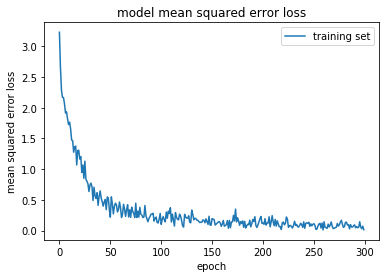

In [89]:
### print the keys contained in the history object
print(history.history.keys())

### plot the training and validation loss for each epoch
fig = plt.figure()
plt.plot(history.history['loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

fig.savefig("Figures/loss.jpg", bbox_inches = "tight")

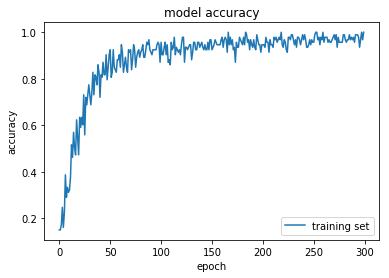

In [90]:
### plot the training and validation loss for each epoch
fig = plt.figure()
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='lower right')
plt.show()

fig.savefig("Figures/acc.jpg", bbox_inches = "tight")